In [1]:
import numpy as np
import os
import pandas as pd
from utils import sample_k_movies
from MAB_class import MABAgent, LinUCB_MABAgent
import random
import matplotlib.pyplot as plt

In [2]:
# Loading the data

movies_data_path = os.path.join(os.path.pardir, 'data/processed_data.csv') 
movies_data = pd.read_csv(movies_data_path)

In [3]:
# Processing the release_date feature and extracting additional features

movies_data['release_date'] = pd.to_datetime(movies_data['release_date'])
movies_data['day_of_year'] = movies_data['release_date'].dt.day_of_year
movies_data['day_of_year_sin'] = np.sin(2 * np.pi * movies_data['day_of_year'] / 365)
movies_data['day_of_year_cos'] = np.cos(2 * np.pi * movies_data['day_of_year'] / 365) 
movies_data['year'] = movies_data['release_date'].dt.year
movies_data['year'] = (movies_data['year'] - movies_data['year'].mean()) / movies_data['year'].std() 

In [4]:
# Load ratings data
path_ratings = os.path.join(os.path.pardir, 'data/ratings.csv')
ratings_df = pd.read_csv(path_ratings)

# Preparing the datasets for the agents
ratings = ratings_df['rating'].to_numpy()
movieId_of_rating = ratings_df['movieId'].to_numpy()
movie_ids = set(ratings_df['movieId'].unique().tolist())

<strong> Constructing a dictionnary that matches movies ID to their title </strong>

In [5]:
# Dictionnary that macthes moviesID to their original title
movieId_title = dict()

titles = movies_data['original_title'].tolist()
movieId = movies_data['movieId'].tolist()

for title, id in zip(titles, movieId):
    movieId_title[id] = title

In [6]:
# Extracting only the movies we will be using and keeping just the relevant columnns

movies_data = movies_data[movies_data['movieId'].isin(movie_ids)]
movies_indices = movies_data['movieId'].to_numpy()
movies_data.drop(columns=['Unnamed: 0', 'index', 'movieId', 'release_date', 'day_of_year', 'count', 'original_title', 'original_nan'], inplace=True)

In [7]:
movies_data.head()

,budget,popularity,revenue,runtime,video,vote_average,vote_count,Science Fiction,GoHands,Vision View Entertainment,...,max_rating_by_main_character_1,min_rating_by_main_character_1,mean_rating_by_main_character_2,max_rating_by_main_character_2,min_rating_by_main_character_2,mean_rating_by_prod_company,ratio_benefit,day_of_year_sin,day_of_year_cos,year
0,0.216912,0.335964,-0.174219,0.728011,-0.045235,0.146495,-0.068832,-0.268429,-0.004686,-0.004686,...,0.549688,-0.578246,3.443951,0.553555,-0.583511,-0.918523,-0.092618,0.635432,0.772157,0.337414
1,11.243154,2.981965,6.593328,0.388473,-0.045235,0.146495,4.211206,3.725297,-0.004686,-0.004686,...,0.549688,-0.578246,2.686671,0.553555,-0.583511,-0.918523,-0.092617,-0.008607,-0.999963,0.462114
2,-0.242515,1.355923,-0.174219,1.903336,-0.045235,1.081932,0.517865,3.725297,-0.004686,-0.004686,...,0.549688,-0.578246,2.634840,0.553555,-0.583511,-0.918523,-0.092618,0.981306,0.192452,-0.826452
3,-0.242515,0.490496,-0.174219,-0.212249,-0.045235,0.926026,0.218405,-0.268429,-0.004686,-0.004686,...,0.549688,-0.578246,2.576529,0.553555,-0.583511,-0.918523,-0.092618,0.501242,-0.865307,-2.364418
4,-0.242515,1.283564,-0.174219,0.519064,-0.045235,0.614213,-0.103464,-0.268429,-0.004686,-0.004686,...,0.549688,-0.578246,1.196496,0.553555,-0.583511,-0.918523,-0.092618,-0.854322,-0.519744,0.378981


In [8]:
# Filling Nan values with mean values for each column
for col in movies_data.columns.tolist():
    movies_data[col].fillna(movies_data[col].mean(skipna=True), inplace=True)

In [9]:
# Checking if there are any NaN values in a column
for col in movies_data.columns.tolist():
    if movies_data[col].isna().sum() > 0:
        print(col)

In [10]:
# Movies matrix is ready :)
A = movies_data.to_numpy()

## <font color='red'> <div align='center'> I will first experiment with 100 movies and 50 features </font></div>

In [11]:
# Define number of features and number of movies
k = 100
m = 50

# Selecting the movies dataset
A_100, indices = sample_k_movies(A, k, m)

# Define the datasets that will be used to train the agents
movies_id_k = movies_indices[indices]
mask = [i for i in range(movieId_of_rating.size) if movieId_of_rating[i] in movies_id_k]
movieId_of_rating_k = movieId_of_rating[mask]
ratings_k = ratings[mask]


# Define the agents parameters
delta = 0.02
epsilon = 1
lambda_ = 1
n_rounds = 50000

true_rewards = ratings_k
rewardsXmovie_indices = movieId_of_rating_k 
actionXmovie_indices = movies_id_k

# Define the agents
Agent_Optimal = MABAgent(A_100, delta, epsilon, n_rounds, true_rewards, rewardsXmovie_indices, actionXmovie_indices)
Agent_LinUCB = LinUCB_MABAgent(A_100, delta, lambda_, n_rounds, true_rewards, rewardsXmovie_indices, actionXmovie_indices)

<strong> Let run the G-optimal design Agent on our selected movies dataset </strong>

In [12]:
cumulative_regret, regret, theta = Agent_Optimal.run()

<strong> Let now run the LinUCB Agent on our selected movies dataset </strong>

In [13]:
cumulative_regret_linUCB, regret_linUCB, theta_linUCB = Agent_LinUCB.run()

<strong> Plotting the cumulative regret for both agents </strong>

c:\Users\Mrabe\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


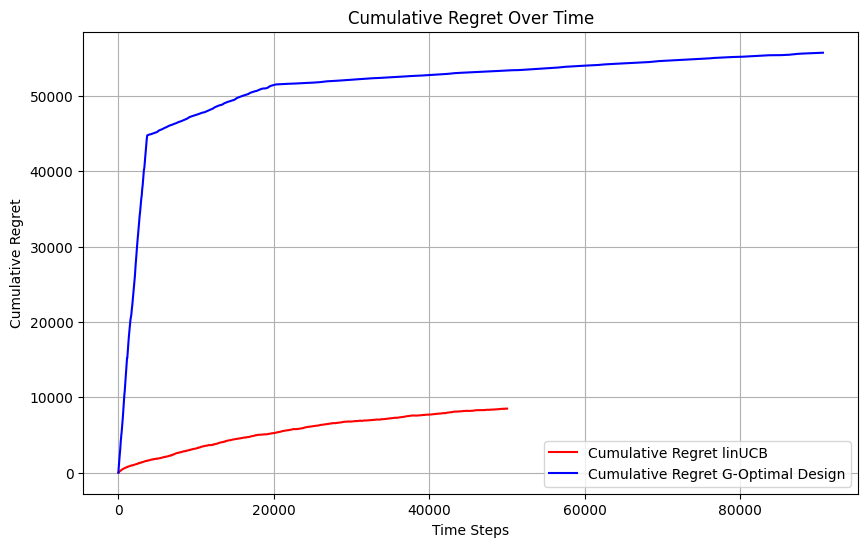

In [14]:
time_steps = range(len(cumulative_regret))  # Assuming each entry corresponds to a time step
time_steps_linUCB = range(len(cumulative_regret_linUCB))  # Assuming each entry corresponds to a time step

# Plotting  
plt.figure(figsize=(10, 6))
plt.plot(time_steps_linUCB, cumulative_regret_linUCB, linestyle='-', color='r', label='Cumulative Regret linUCB')
plt.plot(time_steps, cumulative_regret, linestyle='-', color='b', label='Cumulative Regret G-Optimal Design')

# Customizing the plot
plt.title('Cumulative Regret Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<strong> Plotting the regret for both agents </strong>

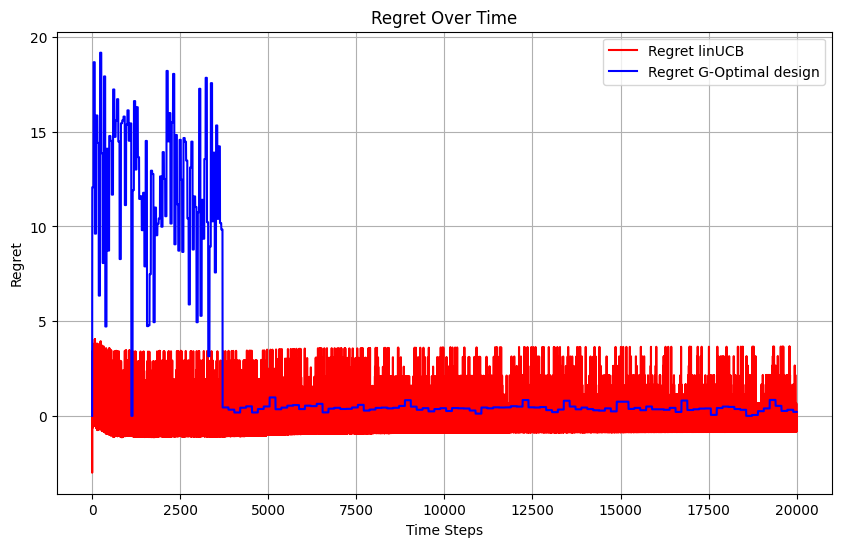

In [15]:
# Plotting  
plt.figure(figsize=(10, 6))
plt.plot(time_steps_linUCB[:20000], regret_linUCB[:20000], linestyle='-', color='r', label='Regret linUCB')
plt.plot(time_steps[:20000], regret[:20000], linestyle='-', color='b', label='Regret G-Optimal design')

# Customizing the plot
plt.title('Regret Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Regret')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<strong> Let see the overall rewards of some selcted movies from our datasets </strong>

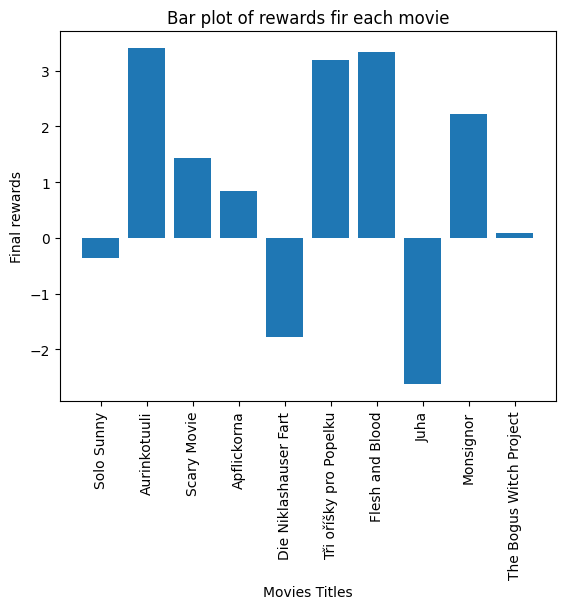

In [16]:
linucb_rewards = (Agent_LinUCB.A @ Agent_LinUCB.theta)

movies_titles = [movieId_title[id] for id in movies_id_k]

# To make it visually better I will keep just 10 movies.

n_samples = 10
# Create bar plot
plt.bar(movies_titles[:n_samples], linucb_rewards[:n_samples])

# Add labels and title
plt.xlabel('Movies Titles')
plt.ylabel('Final rewards')
plt.title('Bar plot of rewards fir each movie')
plt.xticks(rotation=90)

# Show plot
plt.show()

We can now do the recommendation by recommending the movie with the greatest reward

## <font color='red'> <div align='center'> Let experiment with 20 movies and 20 features </font></div>

In [17]:
# Define number of features and number of movies
k = 20 
m = 20

# Selecting the movies dataset
A_20, indices = sample_k_movies(A, k, m)

# Define the datasets that will be used to train the agents
movies_id_k = movies_indices[:k]
mask = [i for i in range(movieId_of_rating.size) if movieId_of_rating[i] in movies_id_k]
movieId_of_rating_k = movieId_of_rating[mask]
ratings_k = ratings[mask]

# Define the agents parameters
delta = 0.02
epsilon = 0.5
lambda_ = 1
n_rounds = 100000

true_rewards = ratings_k
rewardsXmovie_indices = movieId_of_rating_k 
actionXmovie_indices = movies_id_k

# Define the agents
Agent_Optimal = MABAgent(A_20, delta, epsilon, n_rounds, true_rewards, rewardsXmovie_indices, actionXmovie_indices)
Agent_LinUCB = LinUCB_MABAgent(A_20, delta, lambda_, n_rounds, true_rewards, rewardsXmovie_indices, actionXmovie_indices)

<strong> Let run both agents on our selected movies dataset </strong>

In [18]:
cumulative_regret, regret, theta = Agent_Optimal.run()
cumulative_regret_linUCB, regret_linUCB, theta_linUCB = Agent_LinUCB.run()

<strong> Let now plot the cumulative regret of both agents </strong>

c:\Users\Mrabe\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


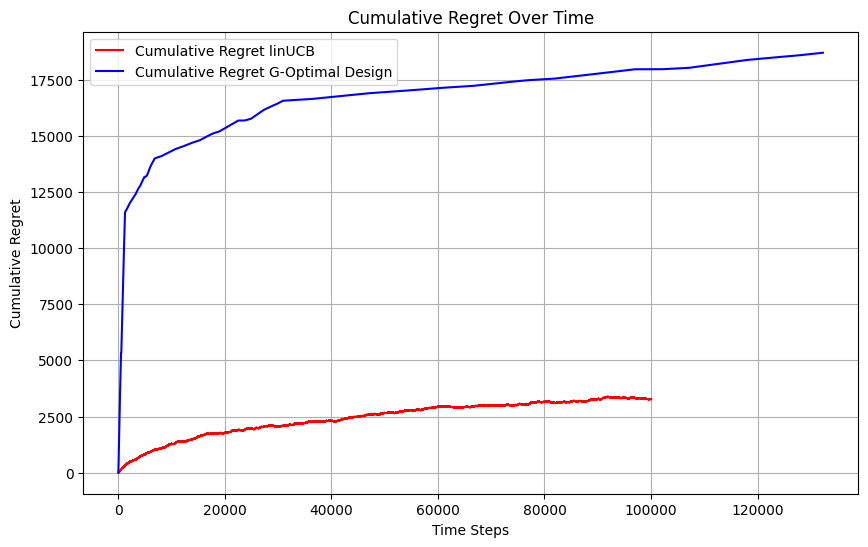

In [19]:
time_steps = range(len(cumulative_regret))  # Assuming each entry corresponds to a time step
time_steps_linUCB = range(len(cumulative_regret_linUCB))  # Assuming each entry corresponds to a time step

# Plotting  
plt.figure(figsize=(10, 6))
plt.plot(time_steps_linUCB, cumulative_regret_linUCB, linestyle='-', color='r', label='Cumulative Regret linUCB')
plt.plot(time_steps, cumulative_regret, linestyle='-', color='b', label='Cumulative Regret G-Optimal Design')

# Customizing the plot
plt.title('Cumulative Regret Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<strong> Let now plot the regret of both agents </strong>

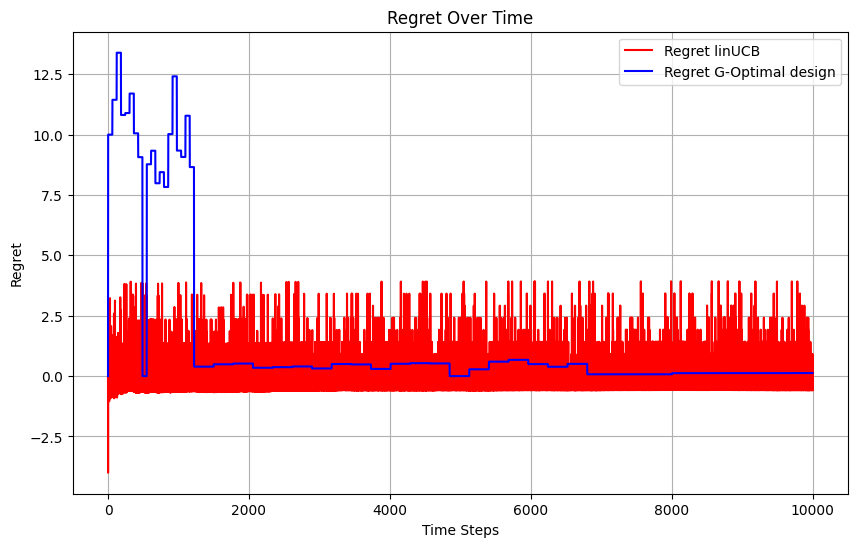

In [20]:
time_steps_linUCB = range(len(cumulative_regret_linUCB))  # Assuming each entry corresponds to a time step

# Plotting  
plt.figure(figsize=(10, 6))
plt.plot(time_steps_linUCB[:10000], regret_linUCB[:10000], linestyle='-', color='r', label='Regret linUCB')
plt.plot(time_steps[:10000], regret[:10000], linestyle='-', color='b', label='Regret G-Optimal design')

# Customizing the plot
plt.title('Regret Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Regret')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<strong> Let see the overall rewards of some selcted movies from our datasets </strong>

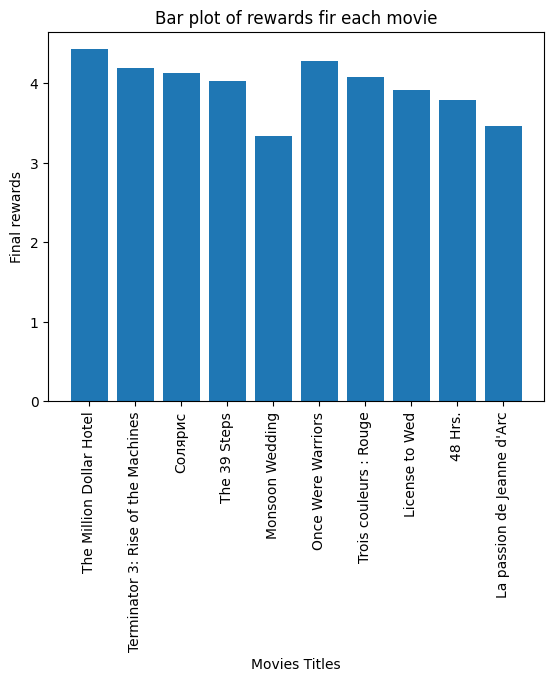

In [21]:
linucb_rewards = (Agent_LinUCB.A @ Agent_LinUCB.theta)

movies_titles = [movieId_title[id] for id in movies_id_k]

# To make it visually better I will keep just 10 movies.

n_samples = 10
# Create bar plot
plt.bar(movies_titles[:n_samples], linucb_rewards[:n_samples])

# Add labels and title
plt.xlabel('Movies Titles')
plt.ylabel('Final rewards')
plt.title('Bar plot of rewards fir each movie')
plt.xticks(rotation=90)

# Show plot
plt.show()

## Conclusion

It’s evident that **linUCB** significantly outperforms the **G-optimal design** across the tested dimensions. Throughout the evaluation period, the regret for linUCB remains relatively small, while the G-optimal design exhibits a sharp increase in regret from the outset.

### Key Observations:
- **linUCB** maintains consistent performance due to its efficient exploration strategy.
- The **G-optimal design** suffers early regret due to its comprehensive exploration of all examples, which is particularly detrimental in the initial stages with limited data.

In summary, linUCB is more adaptive exploration approach provides a clear advantage in scenarios where data is sparse, making it a superior choice for managing regret effectively.
